# Segment Outline PNGs with Contour Masks and SAM2

In [164]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import colorsys
import torch
import random
import pandas as pd
from PIL import Image, ImageEnhance
import ast
from tqdm import tqdm
import re

# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

# Set seed for other libraries if necessary
np.random.seed(SEED)
random.seed(SEED)

In [165]:
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.float16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [166]:
WORK = Path(os.environ.get("WORK", Path.cwd()))
print("WORK:", WORK)

WORK: /mnt/lustre/work/eickhoff/esx061


In [167]:
#%git clone https://github.com/facebookresearch/sam2.git

In [168]:
sam_dir = WORK / "color-concept-entanglement" / "segment-anything-2"
os.chdir(sam_dir)
%pip install -e .

Obtaining file:///mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp311-cp311-linux_x86_64.whl size=13903 sha256=c9559b79e7686b562595e36b4b244b244000a6b9d968b900b773302f19b2c551
  Stored in directory: /tmp/pip-ephem-wheel-cache-n_iyxpsw/wheels/a4/f1/43/0f0846a883930be4032817d76dba580924698cf6ff9d2dcc7a
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
Note: you may need to restart the kernel to use updated packages.


In [169]:
# @title
# !mkdir -p {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/segment-anything-2/checkpoints

In [170]:
# Base data folder
data_folder = WORK / "color-concept-entanglement" / "data"

# Paths
IN_DIR   = data_folder / "outline_images"
OUT_DIR  = data_folder / "color_images"
CV_MASKS = data_folder / "cv_masks"
SAM_MASKS= data_folder / "sam_masks"

# Create needed directories
OUT_DIR.mkdir(parents=True, exist_ok=True)
CV_MASKS.mkdir(parents=True, exist_ok=True)
SAM_MASKS.mkdir(parents=True, exist_ok=True)

# Load CSV
df = pd.read_csv(data_folder / "final_images.csv")

# CV2 mask quality thresholds
MIN_FG = 0.055   # min acceptable foreground ratio (avoid empty masks)
MAX_FG = 0.98   # max acceptable foreground ratio (avoid filled squares)

# SAM2 model setup (edit if you have SAM2 locally)
# - model_cfg is one of the YAMLs in the SAM2 repo (e.g., sam2_hiera_s.yaml)
# - ckpt points to the checkpoint file you downloaded
SAM2_ENABLED = True   # set False to skip SAM2 even if available
model_cfg = "configs/sam2/sam2_hiera_l.yaml"   # e.g., "/path/to/sam2/configs/sam2_hiera_s.yaml"
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"        # e.g., "/path/to/ckpts/sam2_hiera_s.pth"
DEVICE = "cuda"       # "cuda" or "cpu" (cuda recommended for speed)


In [171]:
df

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
1,"['black', 'white', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
4,"['silver', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
...,...,...,...,...,...,...,...,...,...
384,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0
385,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0
386,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0
387,['white'],orange,napkin,https://cdn.vectorstock.com/i/1000v/19/15/fold...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0


## SAM 2

In [172]:
# Try importing SAM2 if installed
SAM2_AVAILABLE = False
if SAM2_ENABLED:
    try:
        from sam2.build_sam import build_sam2
        from sam2.sam2_image_predictor import SAM2ImagePredictor
        SAM2_AVAILABLE = True
        sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
        predictor = SAM2ImagePredictor(sam2_model)
        print("SAM2 is available.")
    except Exception as e:
        print("SAM2 not available or failed to import:", e)
        SAM2_AVAILABLE = False

print("OpenCV version:", cv2.__version__)

SAM2 is available.
OpenCV version: 4.12.0


In [173]:
def show_points(coords, labels, ax, marker_size=375):
    """Sam2 function to show points."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """Sam2 function to show the box over the image."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_mask(mask, ax, random_color=False, borders = True):
    """Visualize mask in the image"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    """Plot ALL images masks in a set"""
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [174]:
def fix_inverse_mask(mask, edge_threshold=0.05, center_fraction=0.5):
    """
    Detects if a SAM-generated mask is inverted and corrects it if necessary.

    Args:
        mask (np.array): A 256x256 binary mask.
        edge_threshold (float): The fraction of the image width/height to consider as an edge.
        center_fraction (float): The fraction of the image width/height to consider as the central region.

    Returns:
        np.array: The corrected mask.
    """
    mask = mask[0]
    height, width = mask.shape

    # Define center region
    center_x_min = int((1 - center_fraction) / 2 * width)
    center_x_max = int((1 + center_fraction) / 2 * width)
    center_y_min = int((1 - center_fraction) / 2 * height)
    center_y_max = int((1 + center_fraction) / 2 * height)

    center_region = mask[center_y_min:center_y_max, center_x_min:center_x_max]

    # Count object and background pixels in the center
    object_count = np.sum(center_region == 1)
    background_count = np.sum(center_region == 0)

    # Define edge regions
    edge_size = int(edge_threshold * width)

    top_edge = mask[:edge_size, :]
    bottom_edge = mask[-edge_size:, :]
    left_edge = mask[:, :edge_size]
    right_edge = mask[:, -edge_size:]

    edges = np.concatenate([top_edge.flatten(), bottom_edge.flatten(), left_edge.flatten(), right_edge.flatten()])

    # Count object and background pixels in the edges
    edge_object_count = np.sum(edges == 1)
    edge_background_count = np.sum(edges == 0)

    # If the center is mostly background (0) and edges are mostly object (1), it's likely inverted
    if background_count > object_count and edge_object_count > edge_background_count:
        return np.expand_dims(1-mask, axis=0)  # Invert the mask

    return np.expand_dims(mask, axis=0)  # Return as is if not inverted

In [175]:
def find_bounding_box_with_threshold(image, block_size=11, C=2):
    """
    Compute a bounding box for an image using adaptive thresholding.
    Assumes that the image is in grayscale mode (PIL 'L').
    """
    np_img = np.array(image)
    # Adaptive thresholding: invert so that white objects become dark and easier to find.
    thresh = cv2.adaptiveThreshold(
        np_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, block_size, C
    )

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return (0, 0, image.width - 1, image.height - 1)

    # Combine all contours to get a bounding rectangle that encompasses them
    all_contours = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    return (x, y, x + w, y + h)

def pad_bbox(bbox, pad, img_width, img_height):
    """Expands the bounding box by a pad value while remaining within image boundaries."""
    x1, y1, x2, y2 = bbox
    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, img_width - 1)
    y2 = min(y2 + pad, img_height - 1)
    return (x1, y1, x2, y2)

## Contour Maps with cv2

In [189]:
def get_cv_mask(
    gray_u8: np.ndarray,
    block_size: int = 15,  # odd
    C: int = 9,
    dilate_px: int = 0,
    close_px: int = 7,
    pad: int = 16,
    min_area_px: int = 0,      # 0 = keep all; or set to drop tiny specks
    keep_largest: bool = False
) -> np.uint8:
    """
    Make a filled object mask where all *corners* are guaranteed background.
    Returns uint8 mask (0/255) same size as gray_u8.
    """
    h, w = gray_u8.shape[:2]
    bs = block_size if block_size % 2 else block_size + 1

    # 1) Detect outline as walls
    walls = cv2.adaptiveThreshold(
        gray_u8, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        bs, C
    )
    if dilate_px > 0:
        walls = cv2.dilate(walls, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_px, dilate_px)), 1)
    if close_px > 0:
        walls = cv2.morphologyEx(walls, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_px, close_px)))

    # 2) Pad with free space
    P = int(max(1, pad))
    ph, pw = h + 2*P, w + 2*P
    walls_pad = np.zeros((ph, pw), np.uint8)
    walls_pad[P:P+h, P:P+w] = walls

    # 3) Flood through free space from all four padded corners
    free = (walls_pad == 0).astype(np.uint8)   # 1 = traversable, 0 = wall
    flood = free.copy()
    ff_mask = np.zeros((ph+2, pw+2), np.uint8)

    seeds = [(0,0), (0,pw-1), (ph-1,0), (ph-1,pw-1)]
    for sx, sy in seeds:
        cv2.floodFill(flood, ff_mask, (sy, sx), 2)  # mark reachable as 2

    # 4) Background = flood==2; Object = not background
    bg_pad = (flood == 2).astype(np.uint8)
    fg_pad = (bg_pad == 0).astype(np.uint8) * 255

    # 5) Unpad back to original size
    fg = fg_pad[P:P+h, P:P+w]

    # 6) Optional cleanup
    if keep_largest or (min_area_px and min_area_px > 0):
        n, lbl, stats, _ = cv2.connectedComponentsWithStats((fg > 0).astype(np.uint8), 8)
        if n > 1:
            if keep_largest:
                largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                fg = np.where(lbl == largest, 255, 0).astype(np.uint8)
            else:
                keep = np.zeros_like(fg)
                for i in range(1, n):
                    if stats[i, cv2.CC_STAT_AREA] >= int(min_area_px):
                        keep[lbl == i] = 255
                fg = keep

    return fg.astype(np.uint8)


## cv2 vs. SAM2

In [190]:
# Compute cv2 and SAM2 masks for all images and store them
all_masks = {}

for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
    img = Image.open(row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)

    # Enhance contrast to help find the object in the image.
    enhancer = ImageEnhance.Contrast(img)
    enhanced_img = enhancer.enhance(2.0)
    enhanced_gray = enhanced_img.convert("L")

    # Compute bounding box over the edited image.
    bbox = find_bounding_box_with_threshold(enhanced_gray, block_size=11, C=2)
    bbox = pad_bbox(bbox, pad=8, img_width=img.width, img_height=img.height)

    # ---- CV MASK ----
    gray_u8 = np.array(enhanced_gray, dtype=np.uint8)
    cv_mask = get_cv_mask(
        gray_u8, pad=64)

    cv_fg = (cv_mask > 0).mean()
    #print(f"CV fg ratio: {cv_fg:.3f}  bbox={bbox}")

    # ---- SAM ----
    # Set the original (non-contrast) image for the predictor
    predictor.set_image(img)

    # Run SAM predictor with bounding box
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array(bbox)[None, :],
        multimask_output=False,
    )

    # Sort by score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    # Fix inverse if needed
    masks = fix_inverse_mask(masks)

    # Keep top SAM mask (H, W) as uint8 0/255 for display/ops
    sam_mask = (masks[0].astype(bool).astype(np.uint8)) * 255

    # ---- Save masks to disk ----
    stem = Path(row["image_path"]).stem
    cv_path  = CV_MASKS / f"{stem}_cv_mask.png"
    sam_path = SAM_MASKS / f"{stem}_sam_mask.png"

    cv2.imwrite(str(cv_path),  cv_mask)
    cv2.imwrite(str(sam_path), sam_mask)

    # (Optional) also save .npy for exact downstream use
    # np.save(CV_DIR / f"{stem}_cv_mask.npy",  (cv_mask > 0).astype(np.uint8))
    # np.save(SAM_DIR / f"{stem}_sam_mask.npy", (sam_mask > 0).astype(np.uint8))

    df.at[idx, "cv_mask_path"]  = str(cv_path)
    df.at[idx, "sam_mask_path"] = str(sam_path)

    all_masks[str(cv_path)]  = (cv_mask > 0).astype(np.uint8)
    all_masks[str(sam_path)] = (sam_mask > 0).astype(np.uint8)

Processing images: 100%|██████████| 355/355 [00:45<00:00,  7.85it/s]


In [178]:
# Display helpers
def checkerboard_pil(size, cell=16):
    w, h = size
    yy, xx = np.ogrid[:h, :w]
    cb = (((xx//cell) + (yy//cell)) % 2) * 255
    return Image.fromarray(np.stack([cb, cb, cb], axis=-1).astype(np.uint8))

def composite_on_checker(img_rgb_pil, mask_u8):
    """Return an RGB preview composited over a checkerboard using mask as alpha."""
    rgba = img_rgb_pil.convert("RGBA")
    alpha = Image.fromarray(mask_u8).convert("L")
    rgba.putalpha(alpha)
    bg = checkerboard_pil(rgba.size, cell=16).convert("RGBA")
    return Image.alpha_composite(bg, rgba).convert("RGB")

def load_mask(mask_path: str, size=None) -> np.ndarray:
    """Load single-channel mask PNG -> uint8 0/255. Optionally resize to size=(W,H)."""
    m = Image.open(mask_path).convert("L")
    if size is not None and m.size != size:
        m = m.resize(size, Image.NEAREST)
    arr = np.array(m, dtype=np.uint8)
    # normalize to 0/255 if it’s 0/1
    if arr.max() == 1:
        arr = arr * 255
    return arr

def show_gallery(df: pd.DataFrame, k: int = 10):
    required = {"image_path", "cv_mask_path", "sam_mask_path"}
    missing_cols = required - set(df.columns)
    if missing_cols:
        raise ValueError(f"df is missing columns: {sorted(missing_cols)}")

    if len(df) == 0:
        print("DataFrame is empty.")
        return

    df_sample = df.sample(min(k, len(df)))

    tiles = []
    for _, row in df_sample.iterrows():
        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except Exception as e:
            print(f"Skip (image load failed): {row.get('image_path')} -> {e}")
            continue

        cv_mask_path  = row.get("cv_mask_path")
        sam_mask_path = row.get("sam_mask_path")

        # Ensure masks match image size (resize masks to image size)
        W, H = img.size
        try:
            cv_mask  = load_mask(cv_mask_path,  size=(W, H))
            sam_mask = load_mask(sam_mask_path, size=(W, H))
        except Exception as e:
            print(f"Skip (mask load failed): {row.get('image_path')} -> {e}")
            continue

        cv_prev  = composite_on_checker(img, cv_mask)
        sam_prev = composite_on_checker(img, sam_mask)

        tiles.append({
            "title": Path(row["image_path"]).name,
            "original": img,
            "cv": cv_prev,
            "sam": sam_prev
        })

    if not tiles:
        print("No valid samples to display.")
        return

    rows = len(tiles)
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, g in enumerate(tiles):
        axes[r, 0].imshow(g["original"]); axes[r, 0].set_title(f"{g['title']} • Original"); axes[r, 0].axis('off')
        axes[r, 1].imshow(g["cv"]);       axes[r, 1].set_title("CV");                      axes[r, 1].axis('off')
        axes[r, 2].imshow(g["sam"]);      axes[r, 2].set_title("SAM");                     axes[r, 2].axis('off')

    plt.tight_layout()
    plt.show()

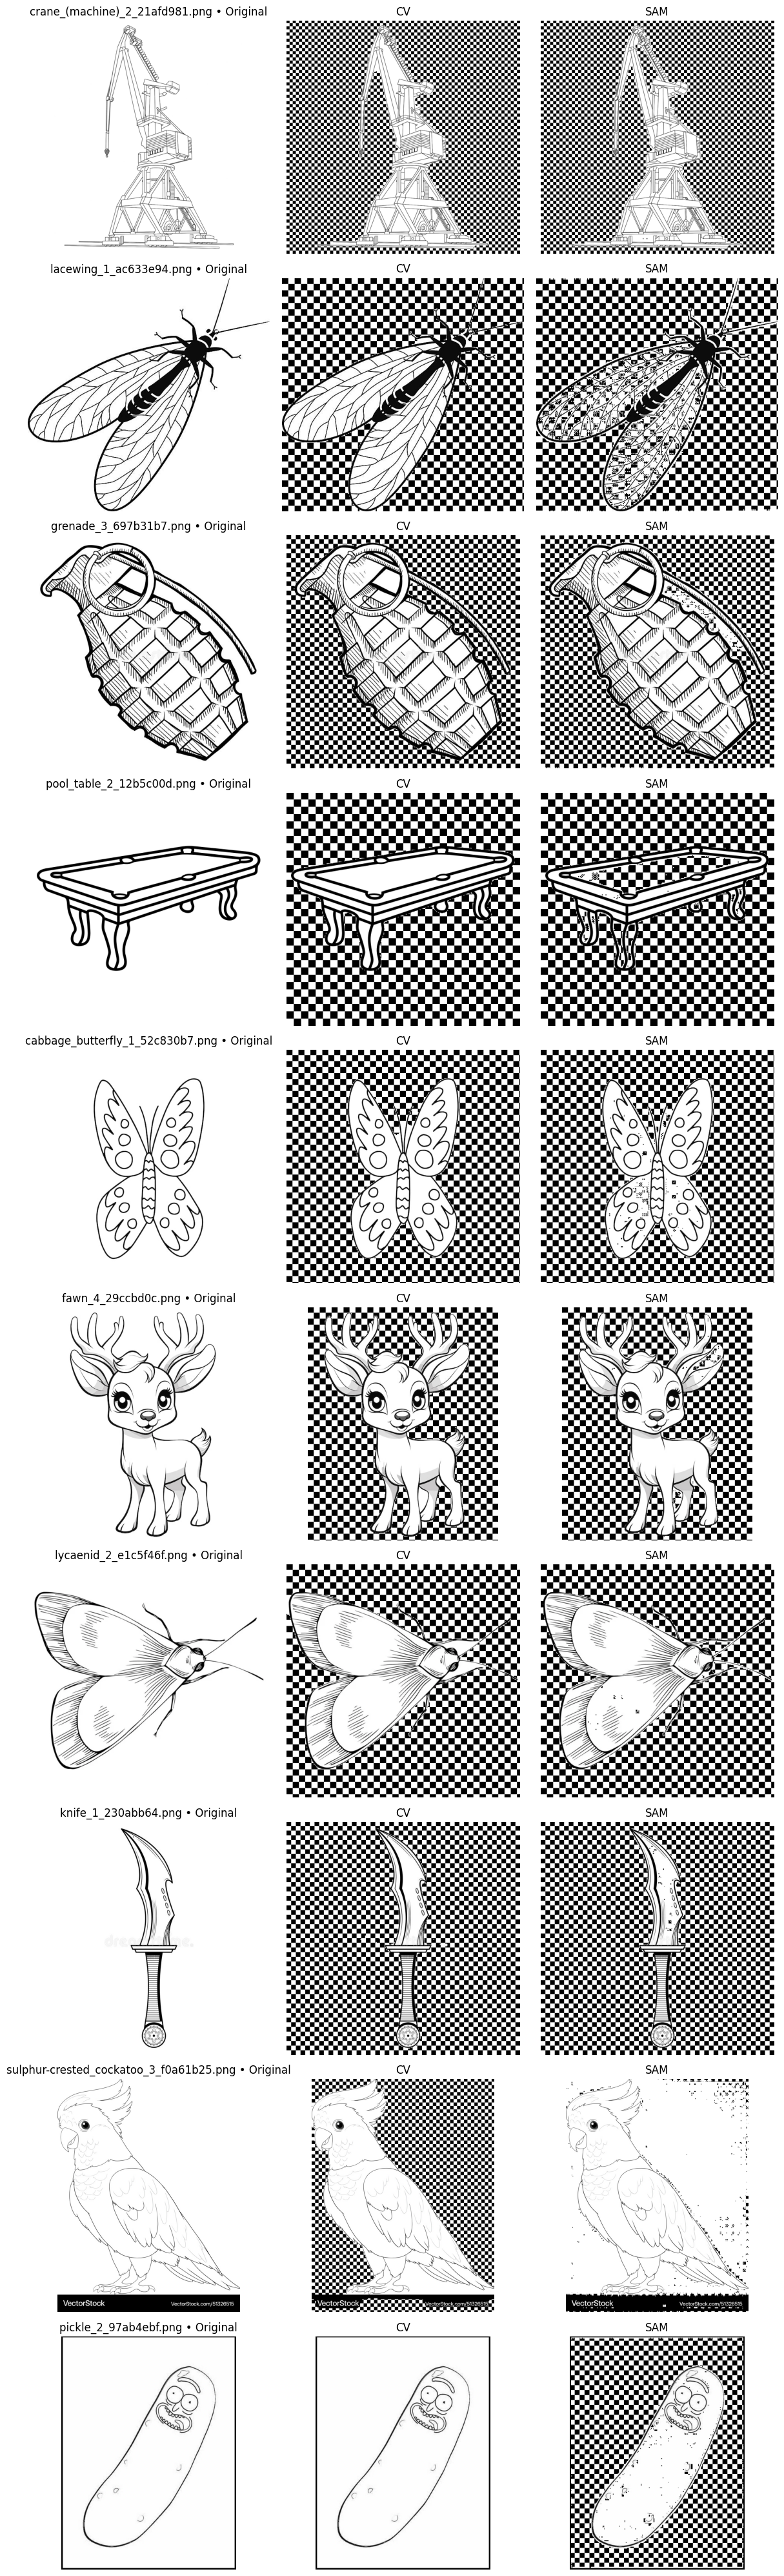

In [191]:
show_gallery(df, k=10)


## Recolor images pixel by pixel

In [180]:
df

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'white', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['silver', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
384,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
385,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
386,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
387,['white'],orange,napkin,https://cdn.vectorstock.com/i/1000v/19/15/fold...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [181]:
f = df.copy()
display(f)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'white', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['silver', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
384,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
385,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
386,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
387,['white'],orange,napkin,https://cdn.vectorstock.com/i/1000v/19/15/fold...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [182]:
# Drop white and black as correct answers and change silver to grey

def clean_colors(ans_list):
    # replace "silver" -> "grey"
    ans_list = ast.literal_eval(ans_list)
    ans_list = ["grey" if c.lower() in ["silver", "gray"] else "yellow" if c.lower() == "gold" else c for c in ans_list]
    # colors we want to drop
    drop_colors = ["white"]
    filtered = [str(c) for c in ans_list if c not in drop_colors]
    return filtered

# apply to your df
# assuming your dataframe is called df and has column "correct_answer"
df["correct_answer"] = (
    df["correct_answer"]
    .apply(clean_colors)
)

# drop rows that ended up with no colors to recolor
df = df[df["correct_answer"].map(len) > 0].reset_index(drop=True)

In [183]:
df[df["correct_answer"].apply(lambda x: x == ["black"])]

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
15,[black],yellow,gorilla,https://t3.ftcdn.net/jpg/12/93/24/38/360_F_129...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",46.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
18,[black],yellow,black-and-tan coonhound,https://www.shutterstock.com/image-vector/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",46.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
23,[black],green,miniature pinscher,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",46.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
28,[black],purple,affenpinscher,https://thumbs.dreamstime.com/b/affenpinscher-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
30,[black],purple,mouse_(computer),https://img.freepik.com/premium-vector/compute...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
47,[black],red,keyboard_(musical),https://img.freepik.com/premium-vector/vector-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
61,[black],pink,Rottweiler,https://storage.googleapis.com/pod_public/750/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
69,[black],purple,limousine,https://img.freepik.com/premium-vector/detaile...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
70,[black],orange,flat-coated retriever,https://i.etsystatic.com/45087911/r/il/c8edab/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
71,[black],pink,espresso maker,https://media.istockphoto.com/id/467663022/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [184]:
# Check number of unique colors after cleaning
corr_colors = df["correct_answer"].explode().unique()
print(f"There are {len(corr_colors)} unique colors in the correct_answer column. They are:")
print(sorted(corr_colors))

There are 10 unique colors in the correct_answer column. They are:
['black', 'blue', 'brown', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'yellow']


In [185]:
def color_remap(pixel, target_color, blend=0.75):
    """
    blend: 1.0 = use recolored fully
           0.0 = keep original
           0.7-0.9 is good to tone down
    """
    target_color = target_color.lower()
  

    r0, g0, b0 = pixel
    h, s, v = colorsys.rgb_to_hsv(r0/255.0, g0/255.0, b0/255.0)

    # Protect outlines
    if v < 0.12 or (v < 0.25 and s < 0.25):
        return pixel

    color_hue_map = {
        "red":    0.0,
        "brown":  0.05,
        "pink":   0.9,
        "orange": 0.07,
        "yellow": 0.15,
        "gold":   0.12,   
        "green":  0.33,
        "blue":   0.55,
        "purple": 0.78,
        "black":  0.0,
        "grey":   0.0,
        "silver": 0.0,
        "white":  0.0,
    }

    neutral_targets = {"grey", "silver", "black"}

    # 2) neutrals
    if target_color in neutral_targets:
        if target_color == "grey":
            new_v = min(max(v, 0.55), 0.75)
            new_s = 0.0
            per_color_blend = 0.85
        elif target_color == "silver":
            new_v = min(max(v, 0.65), 0.9)
            new_s = 0.0
            per_color_blend = 0.85
        elif target_color == "black":
            new_v = min(max(v * 0.2, 0.05), 0.19)
            new_s = 0.0
            per_color_blend = 1.0   

        r1, g1, b1 = colorsys.hsv_to_rgb(0.0, new_s, new_v)
        r1, g1, b1 = int(r1 * 255), int(g1 * 255), int(b1 * 255)

        # use per-color blend
        w = per_color_blend
        r = int((1 - w) * r0 + w * r1)
        g = int((1 - w) * g0 + w * g1)
        b = int((1 - w) * b0 + w * b1)
        return r, g, b
    
    # 3) colorful
    target_hue = color_hue_map.get(target_color, 0.0)
    new_h = target_hue
    
    new_s = 0.75
    new_v = min(max(v, 0.8), 0.95)

    # per-color tweaks
    if target_color == "red":
        new_s = 0.85
        new_v = 0.9
    elif target_color == "brown":
        new_s = 0.7
        new_v = 0.55
    elif target_color == "pink":
        new_s = 0.5
        new_v = 1.0
    elif target_color == "orange":
        new_s = 0.85
        new_v = 0.95
    elif target_color == "yellow":
        new_s = 0.65
        new_v = 1.0
    elif target_color == "gold":
        new_s = 0.6
        new_v = 0.85
    elif target_color == "green":
        new_s = 0.75
        new_v = 0.7
    elif target_color == "blue":
        new_s = 0.9
        new_v = 0.7
    elif target_color == "purple":
        new_s = 0.7
        new_v = 0.85

    r1, g1, b1 = colorsys.hsv_to_rgb(new_h, new_s, new_v)
    r1, g1, b1 = int(r1 * 255), int(g1 * 255), int(b1 * 255)

    r = int((1 - blend) * r0 + blend * r1)
    g = int((1 - blend) * g0 + blend * g1)
    b = int((1 - blend) * b0 + blend * b1)

    return r, g, b

In [186]:
rng = np.random.default_rng(SEED)  # deterministic random subsets

def recolor_subset(arr_rgb, idx_flat, k, target_color):
    """Pixel-wise version (your current one): recolor k random pixels."""
    if k <= 0 or len(idx_flat) == 0:
        return arr_rgb
    chosen = rng.choice(idx_flat, size=min(k, len(idx_flat)), replace=False)
    flat = arr_rgb.reshape(-1, 3)
    for i in chosen:
        r, g, b = flat[i]
        flat[i] = color_remap((int(r), int(g), int(b)), target_color)
    return arr_rgb

def recolor_subset_patches(
    arr_rgb,
    idx_flat,
    pct,
    target_color,
    H,
    W,
    patch_size=16,
):
    """
    Patch-wise recolor, masked with idx_flat to prevent background pixels inside the square patch from being recolored.

    - arr_rgb: (H, W, 3) RGB image as np.uint8
    - idx_flat: 1D np.array of flat indices (FG/BG pixels from the mask)
    - pct: percentage (0..100) of pixels to recolor
    - H, W: image height/width
    - patch_size: side length of each patch
    """
    if len(idx_flat) == 0 or pct <= 0:
        return arr_rgb

    flat = arr_rgb.reshape(-1, 3)

    # turn flat indices into (row, col)
    rows = idx_flat // W
    cols = idx_flat % W

    patch_rows = rows // patch_size
    patch_cols = cols // patch_size
    patch_ids = np.stack([patch_rows, patch_cols], axis=1)
    patch_ids_unique = np.unique(patch_ids, axis=0)

    n_patches = len(patch_ids_unique)
    if n_patches == 0:
        return arr_rgb

    # how many pixels to recolor
    target_pixels = int(round(pct / 100.0 * len(idx_flat)))

    # avg pixels per patch from region
    avg_pixels_per_patch = max(1, len(idx_flat) // n_patches)

    # how many patches to choose to roughly hit target_pixels
    k_patches = max(1, min(n_patches, target_pixels // avg_pixels_per_patch))

    chosen_idx = rng.choice(n_patches, size=k_patches, replace=False)
    chosen_patches = patch_ids_unique[chosen_idx]

    # walk over chosen patches
    for (pr, pc) in chosen_patches:
        r_start = pr * patch_size
        c_start = pc * patch_size
        r_end = min(r_start + patch_size, H)
        c_end = min(c_start + patch_size, W)

        in_patch = (
            (rows >= r_start) & (rows < r_end) &
            (cols >= c_start) & (cols < c_end)
        )
        flat_indices_in_patch = idx_flat[in_patch]

        # per-pixel recolor
        for fi in flat_indices_in_patch:
            r, g, b = flat[fi]
            flat[fi] = color_remap((int(r), int(g), int(b)), target_color)

    return arr_rgb



def generate_variants(row, target_color, use_patches=False, patch_size=16, step_size=10):
    """
    For one image + one target_color → save 21 variants:
      - FG series: 0..100% (11 images)
      - BG series: 10..100% (10 images)
    Can do pixel-wise (old) or patch-wise (new) recoloring.
    """
    img = Image.open(row["image_path"]).convert("RGB")
    W, H = img.size
    m = Image.open(row["cv_mask_path"]).convert("L").resize((W, H), Image.NEAREST)
    mask = (np.array(m, dtype=np.uint8) > 127)

    stem = Path(row["image_path"]).stem
    color_dir = OUT_DIR / f"{stem}_{target_color}"
    color_dir.mkdir(parents=True, exist_ok=True)
    base = np.array(img, dtype=np.uint8)

    idx_all = np.arange(H * W)
    idx_fg = idx_all[mask.flatten()]
    idx_bg = idx_all[~mask.flatten()]

    fg_paths = []
    for pct in range(0, 101, step_size):
        arr = base.copy()
        if use_patches:
            H, W = arr.shape[:2]
            recolor_subset_patches(arr, idx_fg, pct, target_color, H, W, patch_size=patch_size)

        else:
            k = int(round(pct / 100.0 * len(idx_fg)))
            recolor_subset(arr, idx_fg, k, target_color)
        out_path = color_dir / f"FG_{pct:03d}.png"
        Image.fromarray(arr).save(out_path)
        fg_paths.append(out_path)

    bg_paths = []
    for pct in range(10, 101, step_size):
        arr = base.copy()
        if use_patches:
            recolor_subset_patches(arr, idx_bg, pct, target_color, H, W, patch_size=patch_size)
        else:
            k = int(round(pct / 100.0 * len(idx_bg)))
            recolor_subset(arr, idx_bg, k, target_color)
        out_path = color_dir / f"BG_{pct:03d}.png"
        Image.fromarray(arr).save(out_path)
        bg_paths.append(out_path)

    return [str(p) for p in (fg_paths + bg_paths)]

In [187]:
def normalize_colors(c):
    """Return a list of color strings from string or list-like entries."""
    if c is None:
        return []
    if isinstance(c, str):
        return [c.strip().lower()]
    try:
        return [str(x).strip().lower() for x in c if str(x).strip()]
    except Exception:
        return [str(c).strip().lower()]

def _variant_sort_key(p: Path):
    name = p.name
    m_fg = re.match(r"FG_(\d{3})\.png$", name)
    if m_fg:
        return (0, int(m_fg.group(1)))
    m_bg = re.match(r"BG_(\d{3})\.png$", name)
    if m_bg:
        return (1, int(m_bg.group(1)))
    return (9, name)

def collect_variants_for(image_path: str, target_color: str, out_root: Path = OUT_DIR):
    stem = Path(image_path).stem
    color_dir = out_root / f"{stem}_{target_color}"

    if not color_dir.exists():
        return []

    fg = list(color_dir.glob("FG_*.png"))
    bg = list(color_dir.glob("BG_*.png"))

    paths = fg + bg
    return sorted(paths, key=_variant_sort_key)

def show_variants_grid(image_path: str, target_color: str, out_root: Path = OUT_DIR, thumb_w: int = 256):
    """
    Display a 2-row grid:
      Row 1: FG 0..100% (11 images)
      Row 2: BG 10..100% (10 images), shifted right by 1 so both rows end in the same column.
    """
    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    # Split into 11 + 10 (by filename pattern)
    fg_paths = [p for p in paths if "FG_" in p.name]   # 11
    bg_paths = [p for p in paths if "BG_" in p.name]   # 10

    cols = len(fg_paths)
    rows = 2
    fig_w = cols * (thumb_w / 100)  # ~100 px ≈ 1 inch
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, rows * 2.8))

    # Normalize axes to 2 x cols
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
      for c in range(cols):
          ax = ax_row[c]
          ax.axis("off")
          idx = c - start_col
          if 0 <= idx < len(paths_row):
              p = paths_row[idx]
              im = Image.open(p).convert("RGB")
              ax.imshow(im)
              m = re.search(r"(\d{3})(?=\.png$)", p.name)
              pct = int(m.group(1)) if m else ""
              ax.set_title(f"{title_prefix} {pct}%", fontsize=9)

    _draw_row(axes[0], fg_paths, "FG", start_col=0)  # 11 images
    _draw_row(axes[1], bg_paths, "BG", start_col=1)  # shift BG right by 1 (first slot empty)

    fig.suptitle(f"{Path(image_path).name} — {target_color}", fontsize=12)
    plt.tight_layout()
    plt.show()

Will show examples for: ['grey' 'black' 'brown' 'red' 'green' 'yellow' 'orange' 'pink' 'blue'
 'purple']


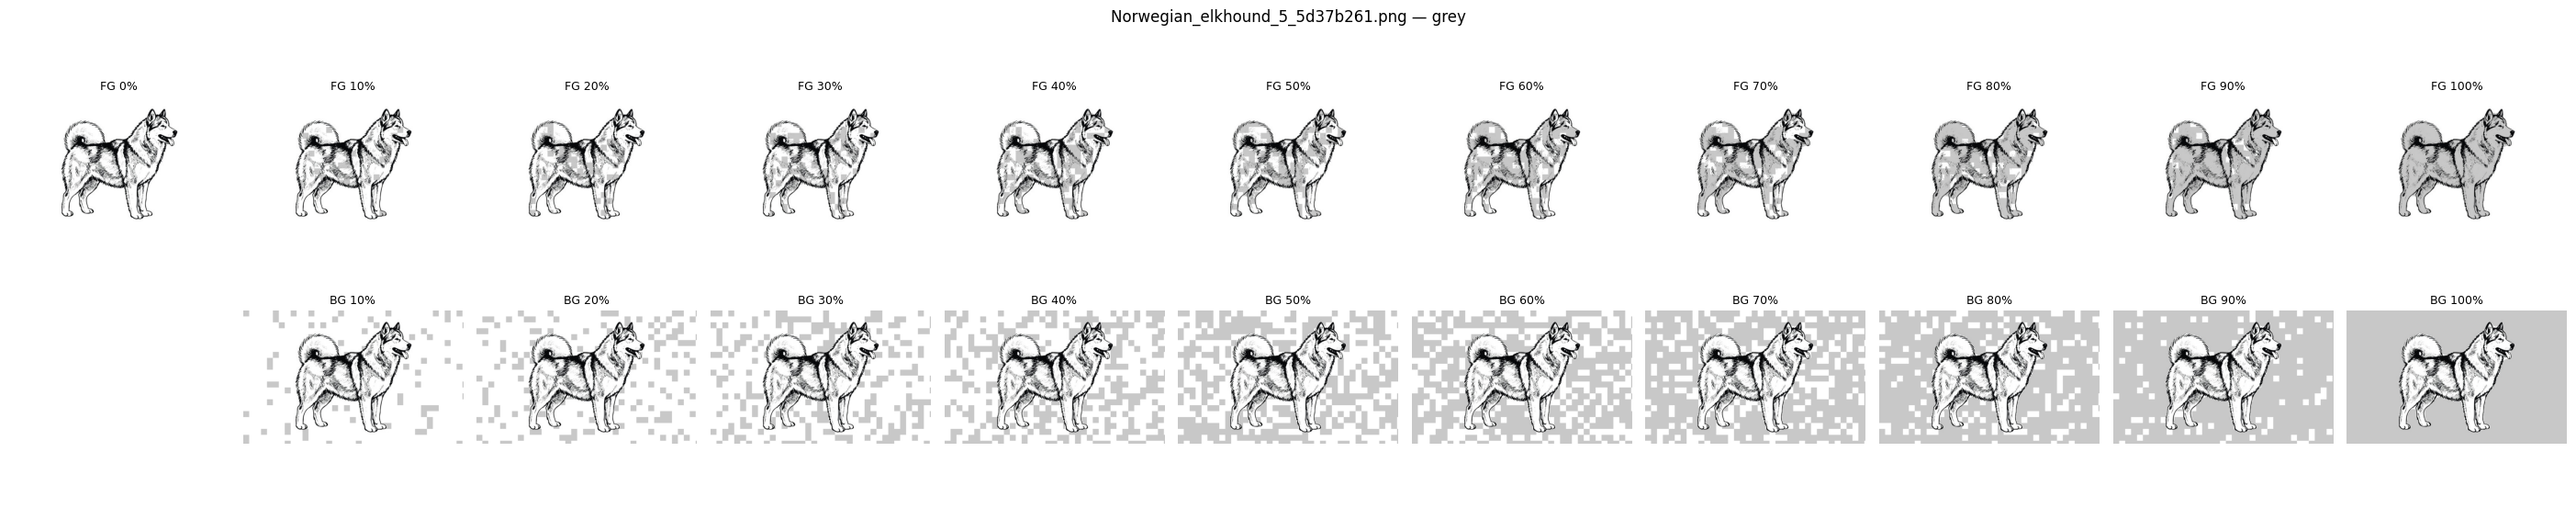

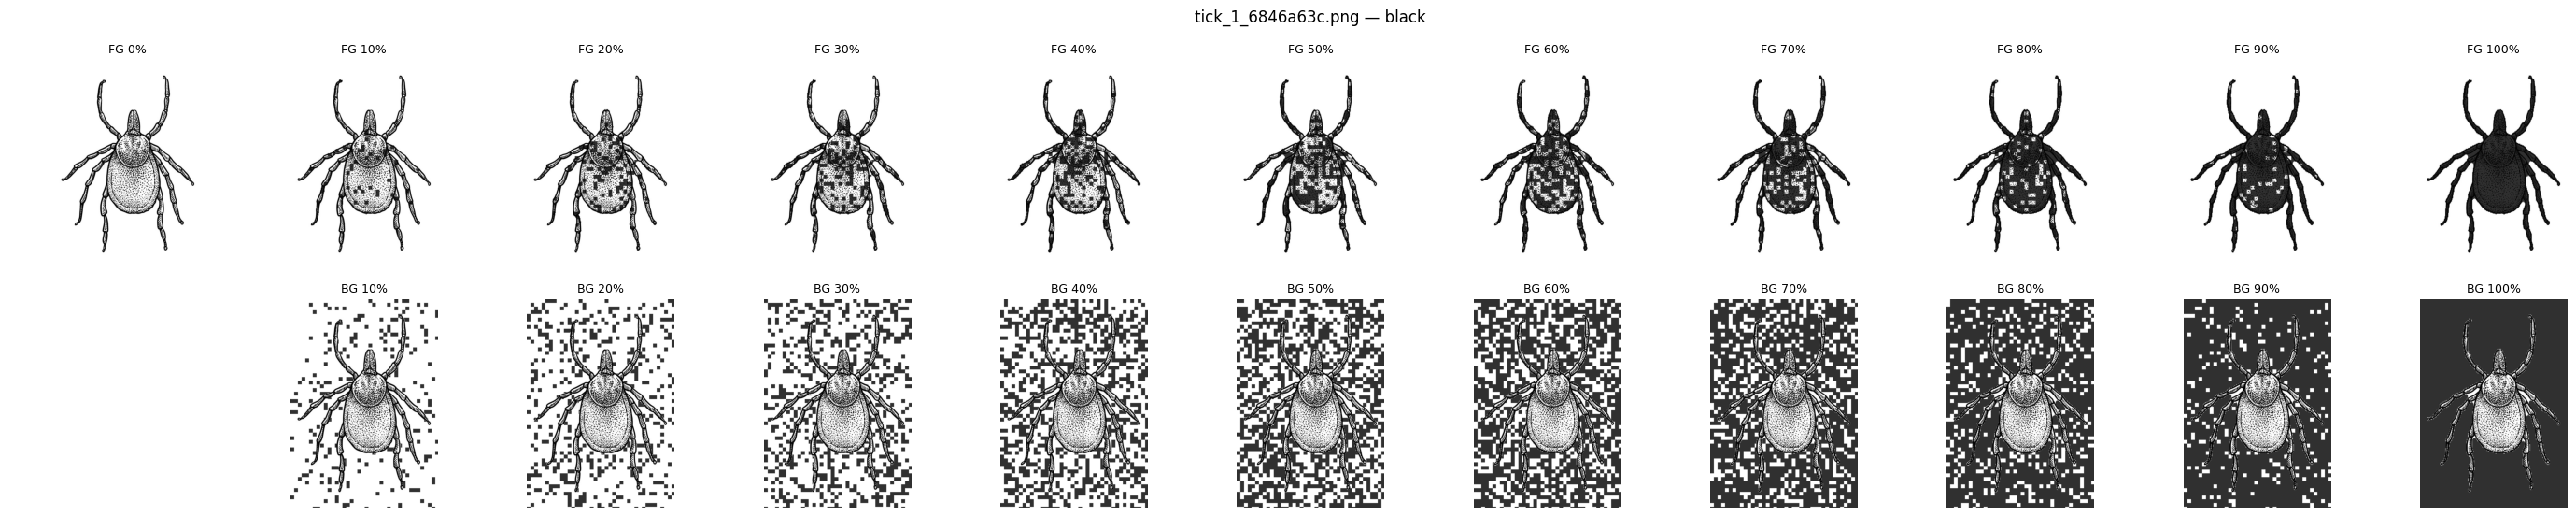

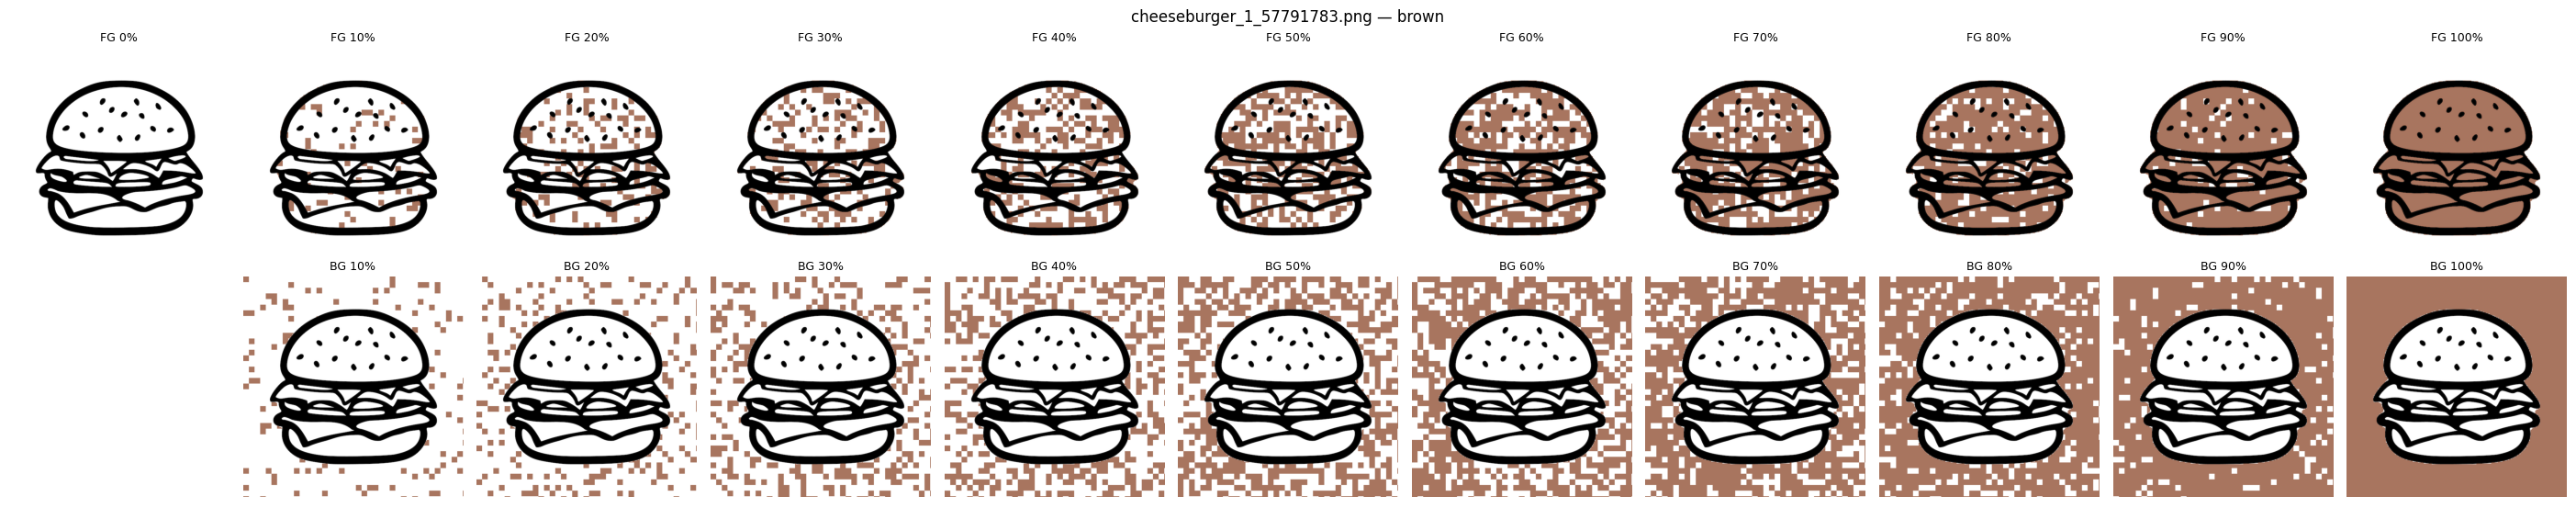

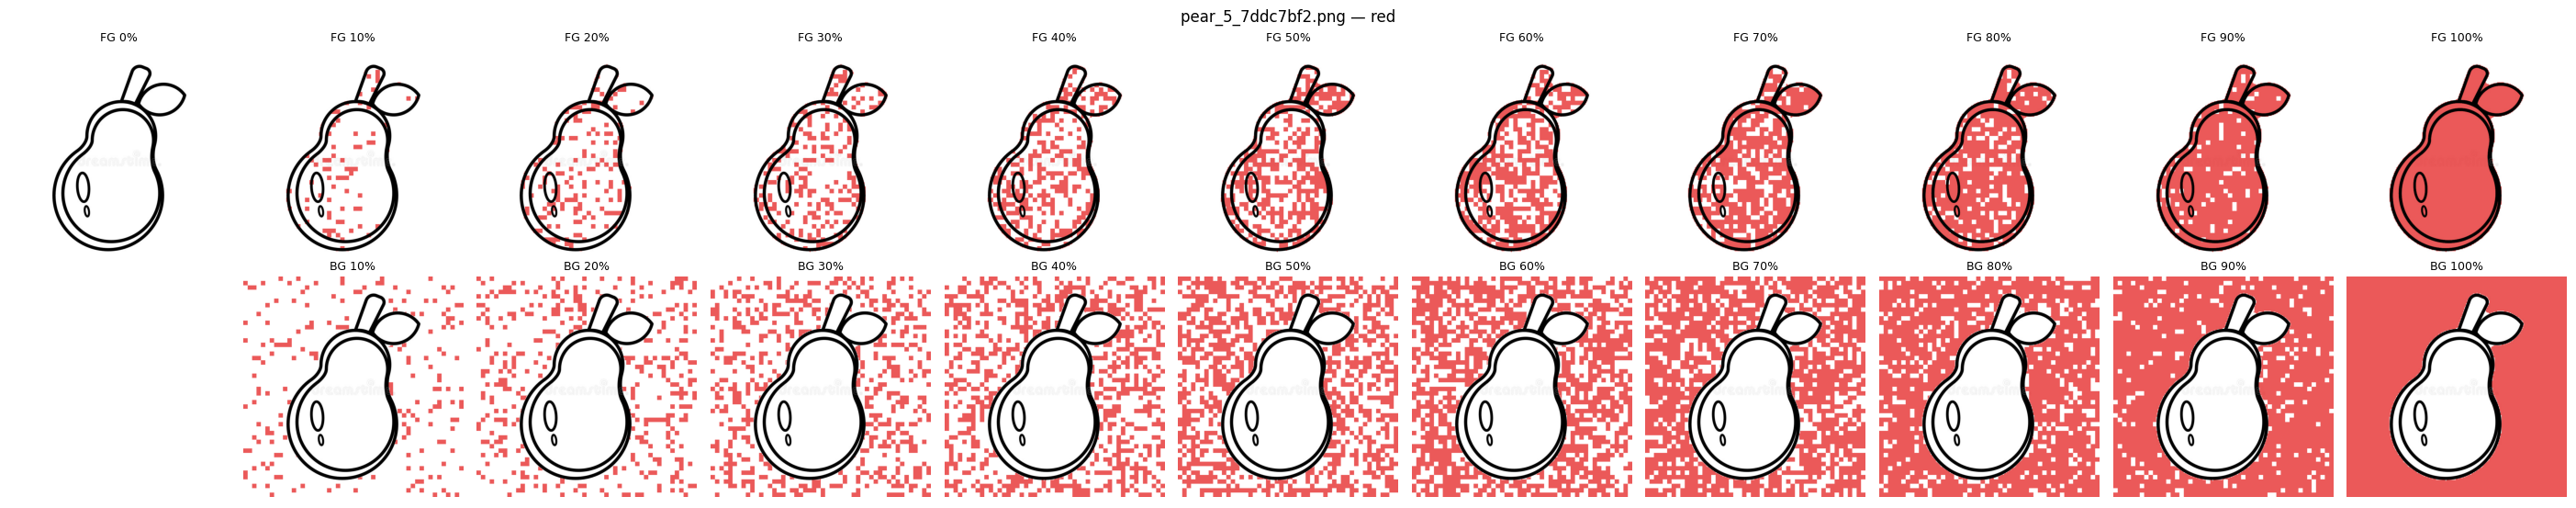

KeyboardInterrupt: 

In [192]:
print("Will show examples for:", corr_colors)

for color in corr_colors:
    mask = df["correct_answer"].apply(lambda lst: any(str(x) == color for x in lst))
    subset = df[mask]

    # pick one example deterministically
    row = subset.sample(1, random_state=SEED).to_dict("records")[0]

    # generate variants for exactly this color
    _ = generate_variants(
        row,
        target_color=color,
        use_patches=True,
        patch_size=16,
    )
    show_variants_grid(row["image_path"], color)